In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.tree import DecisionTreeClassifier, export_text
from sklearn.metrics import accuracy_score, mean_squared_error, confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve, auc
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import classification_report


In [2]:
# Load the dataset
df = pd.read_csv('churn_clean.csv', index_col=0)
#Check Data Types
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 10000 entries, 1 to 10000
Data columns (total 49 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Customer_id           10000 non-null  object 
 1   Interaction           10000 non-null  object 
 2   UID                   10000 non-null  object 
 3   City                  10000 non-null  object 
 4   State                 10000 non-null  object 
 5   County                10000 non-null  object 
 6   Zip                   10000 non-null  int64  
 7   Lat                   10000 non-null  float64
 8   Lng                   10000 non-null  float64
 9   Population            10000 non-null  int64  
 10  Area                  10000 non-null  object 
 11  TimeZone              10000 non-null  object 
 12  Job                   10000 non-null  object 
 13  Children              10000 non-null  int64  
 14  Age                   10000 non-null  int64  
 15  Income                10

In [3]:
# Handle missing values and outliers
print("Initial Missing Values:")
print(df.isnull().sum())

# Identify columns with missing values
columns_with_missing = df.columns[df.isnull().any()]

# Replace missing values or drop rows/columns as needed
# Impute missing values for numerical columns (replace with mean)
for col in columns_with_missing:
    if df[col].dtype == 'float64' or df[col].dtype == 'int64':
        df[col].fillna(df[col].mean(), inplace=True)

# Impute missing values for categorical columns (replace with mode)
for col in columns_with_missing:
    if df[col].dtype == 'object':
        df[col].fillna(df[col].mode()[0], inplace=True)
# Display information about missing values after imputation
print("\nMissing Values After Imputation:")
print(df.isnull().sum())

Initial Missing Values:
Customer_id                0
Interaction                0
UID                        0
City                       0
State                      0
County                     0
Zip                        0
Lat                        0
Lng                        0
Population                 0
Area                       0
TimeZone                   0
Job                        0
Children                   0
Age                        0
Income                     0
Marital                    0
Gender                     0
Churn                      0
Outage_sec_perweek         0
Email                      0
Contacts                   0
Yearly_equip_failure       0
Techie                     0
Contract                   0
Port_modem                 0
Tablet                     0
InternetService         2129
Phone                      0
Multiple                   0
OnlineSecurity             0
OnlineBackup               0
DeviceProtection           0
TechSupport        

In [4]:
df.head(5)

,Customer_id,Interaction,UID,City,State,County,Zip,Lat,Lng,Population,...,MonthlyCharge,Bandwidth_GB_Year,Item1,Item2,Item3,Item4,Item5,Item6,Item7,Item8
CaseOrder,,,,,,,,,,,,,,,,,,,,,
1,K409198,aa90260b-4141-4a24-8e36-b04ce1f4f77b,e885b299883d4f9fb18e39c75155d990,Point Baker,AK,Prince of Wales-Hyder,99927,56.25100,-133.37571,38,...,172.455519,904.536110,5,5,5,3,4,4,3,4
2,S120509,fb76459f-c047-4a9d-8af9-e0f7d4ac2524,f2de8bef964785f41a2959829830fb8a,West Branch,MI,Ogemaw,48661,44.32893,-84.24080,10446,...,242.632554,800.982766,3,4,3,3,4,3,4,4
3,K191035,344d114c-3736-4be5-98f7-c72c281e2d35,f1784cfa9f6d92ae816197eb175d3c71,Yamhill,OR,Yamhill,97148,45.35589,-123.24657,3735,...,159.947583,2054.706961,4,4,2,4,4,3,3,3
4,D90850,abfa2b40-2d43-4994-b15a-989b8c79e311,dc8a365077241bb5cd5ccd305136b05e,Del Mar,CA,San Diego,92014,32.96687,-117.24798,13863,...,119.956840,2164.579412,4,4,4,2,5,4,3,3
5,K662701,68a861fd-0d20-4e51-a587-8a90407ee574,aabb64a116e83fdc4befc1fbab1663f9,Needville,TX,Fort Bend,77461,29.38012,-95.80673,11352,...,149.948316,271.493436,4,4,4,3,4,4,4,5


In [5]:
#Categorical Columns to Numeric
categorical_columns = ['Techie','Port_modem','Churn','OnlineSecurity','DeviceProtection', 'TechSupport', 'PaperlessBilling', 'Tablet', 'Phone', 'Multiple', 'OnlineBackup', 'StreamingTV', 'StreamingMovies']
for column in categorical_columns:
    df[column] = df[column].map({'Yes': 1, 'No': 0})

In [6]:
#Format
df['Age'] = df['Age'].fillna(0).astype(int)
df['Lng'] = df['Lng'].fillna(0).abs()

In [7]:
area_mapping = {'Urban': 0,'Suburban': 1,'Rural': 2}
marital_mapping = {'Widowed': 0,'Married': 1,'Separated': 2,'Never Married': 3,'Divorced' :4}
gender_mapping = {'Male':0,'Female': 1,'Prefer not to answer': 2}
contract_mapping = {'One year': 0,'Month-to-month': 1,'Two Year': 2}
InternetService_mapping = {'DSL': 0,'Fiber Optic': 1,'None': 2}
PaymentMethod_mapping = {'Bank Transfer(automatic)': 0,'Credit Card (automatic)': 1,'Mailed Check': 2, 'Electronic Check': 3}



df['Area'] = df['Area'].map(area_mapping)
df['Marital'] = df['Marital'].map(marital_mapping)
df['Gender'] = df['Gender'].map(gender_mapping)
df['Contract'] = df['Contract'].map(contract_mapping)
df['InternetService'] = df['InternetService'].map(InternetService_mapping)
df['PaymentMethod'] = df['PaymentMethod'].map(PaymentMethod_mapping)

In [8]:
#Missing Values
df['Gender']= df['Gender'].fillna(df['Gender'].mode()[0])
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 10000 entries, 1 to 10000
Data columns (total 49 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Customer_id           10000 non-null  object 
 1   Interaction           10000 non-null  object 
 2   UID                   10000 non-null  object 
 3   City                  10000 non-null  object 
 4   State                 10000 non-null  object 
 5   County                10000 non-null  object 
 6   Zip                   10000 non-null  int64  
 7   Lat                   10000 non-null  float64
 8   Lng                   10000 non-null  float64
 9   Population            10000 non-null  int64  
 10  Area                  10000 non-null  int64  
 11  TimeZone              10000 non-null  object 
 12  Job                   10000 non-null  object 
 13  Children              10000 non-null  int64  
 14  Age                   10000 non-null  int32  
 15  Income                10

In [9]:
# Save the cleaned dataset to a new CSV file
df.to_csv('cleaned_churn_data.csv', index=False)

In [10]:
selected_columns = ['MonthlyCharge', 'Bandwidth_GB_Year', 'Outage_sec_perweek', 'TechSupport', 'PaperlessBilling', 'Churn']
data= df[selected_columns]

In [11]:
description =data.describe(include='all')
print(description)

       MonthlyCharge  Bandwidth_GB_Year  Outage_sec_perweek   TechSupport  \
count   10000.000000       10000.000000        10000.000000  10000.000000   
mean      172.624816        3392.341550           10.001848      0.375000   
std        42.943094        2185.294852            2.976019      0.484147   
min        79.978860         155.506715            0.099747      0.000000   
25%       139.979239        1236.470827            8.018214      0.000000   
50%       167.484700        3279.536903           10.018560      0.000000   
75%       200.734725        5586.141370           11.969485      1.000000   
max       290.160419        7158.981530           21.207230      1.000000   

       PaperlessBilling         Churn  
count      10000.000000  10000.000000  
mean           0.588200      0.265000  
std            0.492184      0.441355  
min            0.000000      0.000000  
25%            0.000000      0.000000  
50%            1.000000      0.000000  
75%            1.000000   

In [12]:

X = data.drop(["Churn"], axis=1).copy()
y = data["Churn"].copy()

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = 0.8, test_size=0.2, random_state = 42, stratify = y)

# Save the training and test sets to CSV files
X_train.to_csv('task2_Xtrain.csv', index=False)
X_test.to_csv('task2_Xtest.csv', index=False)
y_train.to_csv('task2_ytrain.csv', index=False)
y_test.to_csv('task2_ytest.csv', index=False)


# Display the shapes of the training and test sets
print("Training Set Shape X:", X_train.shape)
print("Test Set Shape X:", X_test.shape)
print("Training Set Shape Y:", y_train.shape)
print("Test Set Shape Y:", y_test.shape)

Training Set Shape X: (8000, 5)
Test Set Shape X: (2000, 5)
Training Set Shape Y: (8000,)
Test Set Shape Y: (2000,)


In [13]:
# Define hyperparameters for Decision Tree
params_dt = {
    'max_depth': range(1, 11),
    'min_samples_leaf': [0.04, 0.06, 0.08, 0.10, 0.12, 0.14, 0.16, 0.18, 0.20, 0.22]
}

# GridSearchCV for Decision Tree
grid_dt = GridSearchCV(
    estimator=DecisionTreeClassifier(random_state=42),
    param_grid=params_dt,
    scoring='roc_auc',
    cv=5,
    n_jobs=-1
)

# Fit grid search to training data
grid_dt.fit(X_train, y_train)

# Get the best estimator from grid search
best_model = grid_dt.best_estimator_

# Predict and evaluate on the test set
initial_y_pred = best_model.predict(X_test)
acc_test = accuracy_score(y_test, initial_y_pred)
print('Test set accuracy of best decision tree: {:.2f}'.format(acc_test)) 

# Compute and print test set ROC AUC score
initial_roc_auc = roc_auc_score(y_test, best_model.predict_proba(X_test)[:, 1])
print('Test set ROC AUC score: {:.3f}'.format(initial_roc_auc))

Test set accuracy of best decision tree: 0.84
Test set ROC AUC score: 0.902


In [14]:
best_model

DecisionTreeClassifier(max_depth=6, min_samples_leaf=0.04, random_state=42)

In [15]:
# Define hyperparameters for AdaBoost
params_ada = {
    'n_estimators': [160, 180, 200],
    'learning_rate': [0.9, 1.0, 1.1, 1.2, 1.3]
}

# Instantiate Decision Tree with fixed parameters
final_dt = DecisionTreeClassifier(max_depth=8, min_samples_leaf=0.06, random_state=42)

# GridSearchCV for AdaBoost with Decision Tree as base estimator
grid_ada = GridSearchCV(
    estimator=AdaBoostClassifier(estimator=final_dt, random_state=42),
    param_grid=params_ada,
    scoring='roc_auc',
    cv=5,
    n_jobs=-1
)

# Fit grid search to training data
grid_ada.fit(X_train, y_train)

# Display the best parameters
print(grid_ada.best_params_)

{'learning_rate': 1.0, 'n_estimators': 180}


In [18]:
# Instantiate and fit final AdaBoost model
final_ada = AdaBoostClassifier(estimator=DecisionTreeClassifier(max_depth=8, min_samples_leaf=0.06, random_state=42),
                                n_estimators=200, learning_rate=1.2, random_state=42)
final_ada.fit(X_train, y_train)

# Get predicted probabilities for the positive class
final_ada_y_pred_proba = final_ada.predict_proba(X_test)[:, 1]

# Evaluate and print test set accuracy
final_acc_test = accuracy_score(y_test, final_ada.predict(X_test))
print('Test set accuracy of final decision tree model: {:.2f}'.format(final_acc_test)) 

# Evaluate and print test-set roc_auc_score
final_roc_auc = roc_auc_score(y_test, final_ada_y_pred_proba)
print('\nThe Area Under the Curve (AUC) score of the final decision tree model is: {:.2f}'.format(final_roc_auc))

# Print confusion matrix
final_matrix = confusion_matrix(y_test, final_ada.predict(X_test))
print("\nThe confusion matrix for this AdaBoosted Decision Tree model:\n", final_matrix)

# Print mean squared error and root mean squared error
mse = mean_squared_error(y_test, final_ada.predict(X_test))
root_mse = mse ** 0.5
print(f"\nThe mean squared error of this model is: {mse}")
print(f"The root mean squared error of this model is: {round(root_mse, 2)}\n")

# Print classification report
print("Classification Report:\n", classification_report(y_test, final_ada.predict(X_test)))

Test set accuracy of final decision tree model: 0.82

The Area Under the Curve (AUC) score of the final decision tree model is: 0.89

The confusion matrix for this AdaBoosted Decision Tree model:
 [[1326  144]
 [ 207  323]]

The mean squared error of this model is: 0.1755
The root mean squared error of this model is: 0.42

Classification Report:
               precision    recall  f1-score   support

           0       0.86      0.90      0.88      1470
           1       0.69      0.61      0.65       530

    accuracy                           0.82      2000
   macro avg       0.78      0.76      0.77      2000
weighted avg       0.82      0.82      0.82      2000



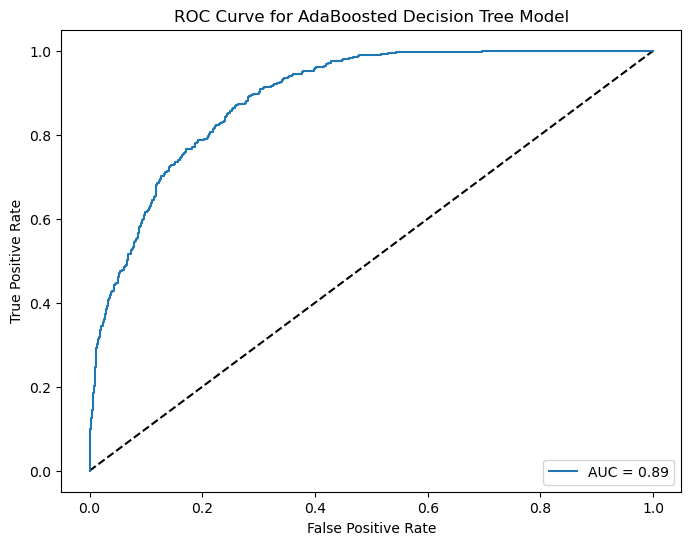

In [19]:
# Plot ROC curve
fpr, tpr, thresholds = roc_curve(y_test, final_ada_y_pred_proba)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr, label=f'AUC = {roc_auc:.2f}')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for AdaBoosted Decision Tree Model')
plt.legend(loc='lower right')
plt.show()
